In [1]:
%cd ../..

c:\Boyko Boev\Stock-Market-Prediction\src


c:\Boyko Boev\Stock-Market-Prediction\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.cnn_v3.cnn_model import build_model, train_model, save_cnn_model, load_cnn_model
from models.cnn_v3.cnn_normalize import get_cnn_data, get_images_dataset, get_classes_and_files
from utils.chart import config_chart, plot_model_performance, plot_scatter_data, plot_distribution_data, plot_direction_comparison
from constants import SP500_TICKER, NASDAQ_TICKER, DJI_TICKER
from sklearn.metrics import accuracy_score



---

## For **build_model** function

Конволюционна невронна мрежа (CNN) за класификация на изображения

Структура:
- Input(INPUT_SHAPE) определя входния слой, който получава изображения със зададената форма (256, 256, 4):
    - 256: Широчина на изображението в пиксели.
    - 256: Височина на изображението в пиксели.
    - 4: Брой канали в изображението (вероятно RGBA).
- Conv2D(filters=32, kernel_size=(3, 4), activation='relu'):
    - Използват се три конволюционни слоя за извличане на характеристики:
    - Прилага 32 филтъра с размер (3x4) към входа, извличайки характеристики.
    - Използва ReLU активация за нелинейност.
    - Следват подобни конволюции с намаляващ брой филтри (16 и 8), за да се уловят потенциално по-високо ниво характеристики.
    - Размерът на входните данни се намалява леко след всеки конволюционен слой поради валидиране
- Flatten(): 
    - Преобразува 2D feature maps от конволюционните слоеве в 1D вектор за подаване към плътно свързаните слоеве.
- Dense(units=32, activation='relu'):
    - Създава плътен слой с 32 неврона и ReLU активация.
- Dense(units=5, activation='softmax'):
    - Създава изходния слой с 5 неврона (за 5 класа изображения).
    - softmax активация за разпределение на вероятностите между класовете.


Описание:
- Използва библиотеката tensorflow.keras за изграждане на CNN модела.
- Функцията build_model е дефинирана, за да създаде архитектурата на CNN.
- model = Sequential() инициализира последователен модел, който подрежда слоевете линейно.
- model.compile(...) конфигурира процеса на обучение:
- optimizer=Adam(0.001): Използва оптимизатора Adam с коефициент на обучение 0.001.
- loss='sparse_categorical_crossentropy': Определя функцията на загубата за класификация с множество класове.
- metrics=['accuracy']: Указва метриката за точност, която да се следи по време на обучението.
- Функцията връща компилирания model, готов за обучение върху данните с изображения.

In [3]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 253, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 250, 16)        │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 250, 247, 8)         │           1,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 494000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      15,808,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,817,469 (60.34 MB)

 Trainable params: 15,817,469 (60.34 MB)

 Non-trainable params: 0 (0.00 B)


---

## For **train_model** function

Функцията train_model предоставя основен процес за обучение и оценка на CNN модел за класификация на изображения. Тя използва TensorBoard за визуализиране на процеса на обучение и помага за наблюдение на производителността на модела.

Описание:
- Извиква функцията build_model за да създаде CNN модел за класификация на изображения.
- Създава обект TensorBoard callback.
    - Този callback се използва за визуализиране на процеса на обучение в TensorBoard, което е инструмент за наблюдение и отстраняване на грешки при машинно обучение.
    - Callback-ът е конфигуриран да записва резултатите в директорията, определена от константата CNN_V2_LOG_DIRECTORY.
- Използва метода fit на модела за обучение по данните за обучение (x_train и y_train).
    - x_train (np.ndarray): Триизмерен NumPy масив, съдържащ изображения за обучение.
    - y_train (np.ndarray): Едноизмерен NumPy масив, съдържащ целеви класове за изображенията за обучение.
    - Определя се брой епохи на обучение (epochs=10). Епохата е пълен цикъл през всички данни за обучение.
    - Определя се брой стъпки на епоха (steps_per_epoch=100). Стъпката е мини-пакет от данни за обучение.
    - Callback-ът tensorboard_callback се добавя като аргумент към метода fit, за да се активира визуализацията на обучението в TensorBoard.
- След обучението функцията използва метода evaluate на модела за оценка на неговата производителност на данните за тестване (x_test и y_test).
    - x_test (np.ndarray): Триизмерен NumPy масив, съдържащ изображения за тестване.
    - y_test (np.ndarray): Едноизмерен NumPy масив, съдържащ целеви класове за изображенията за тестване.


In [4]:
# nasdaq_train, nasdaq_test, nasdaq_predict= get_cnn_data(NASDAQ_TICKER)
train, test, predict = get_cnn_data(NASDAQ_TICKER)

x_train = train["x"] 
y_train = train["y"]

x_test = test["x"]
y_test = test["y"]

x_predict = predict["x"]
y_predict = predict["y"]


print("Train data:")
print(x_train.shape)
print(y_train.shape)

print("Test data:")
print(x_test.shape)
print(y_test.shape)

print("Predict data:")
print(x_predict.shape)
print(y_predict.shape)

Train data:
(1584, 256, 256, 4)
(1584,)
Test data:
(198, 256, 256, 4)
(198,)
Predict data:
(198, 256, 256, 4)
(198,)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.4725 - loss: 7.4528
Epoch 2/10


C:\Programs\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - accuracy: 0.6862 - loss: 0.7995
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 385ms/step - accuracy: 0.7823 - loss: 0.5659
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.8356 - loss: 0.4428
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - accuracy: 0.9113 - loss: 0.2633
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.9621 - loss: 0.1276
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 382ms/step - accuracy: 0.9853 - loss: 0.0478
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.9994 - loss: 0.0077
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.9985 - loss: 0.0037
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.9999 - loss: 0.0018
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7188 - loss: 1.6169


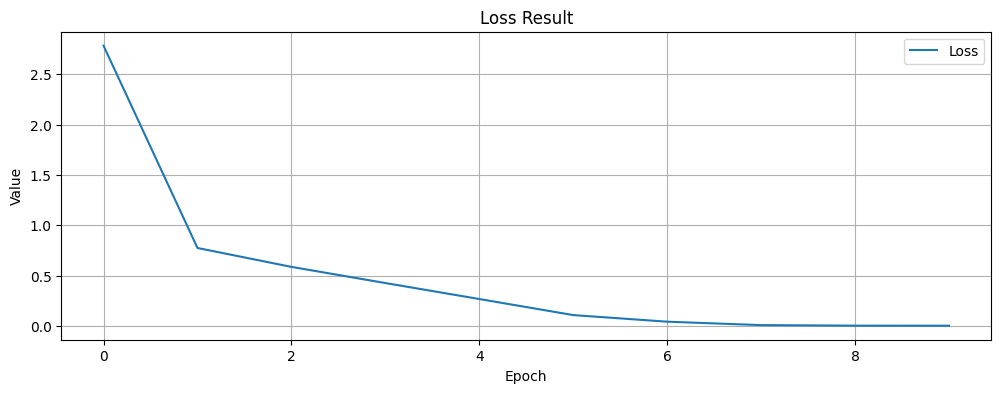

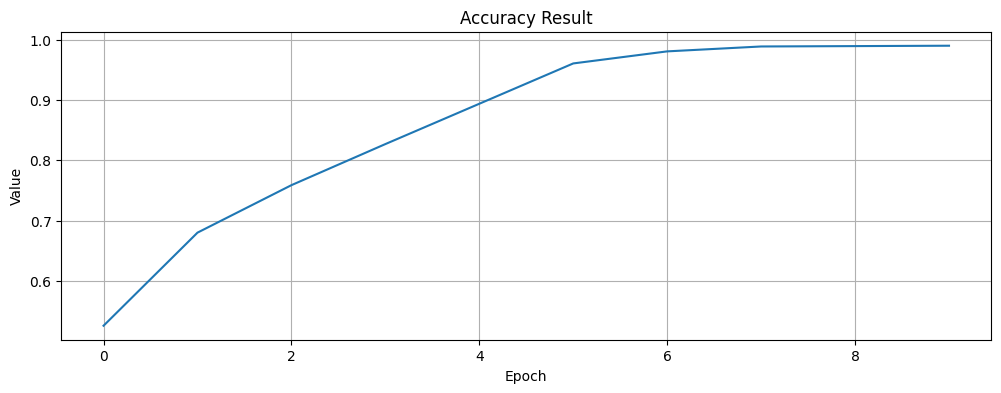

Train result:
Test result:
[1.7433116436004639, 0.7272727489471436]


In [5]:
model, fit_result, evaluate_result = train_model(x_train, x_test, y_train, y_test) 

plot_model_performance(fit_result)

print("Train result:")
print(fit_result)

print("Test result:")
print(evaluate_result)

save_cnn_model(model)

In [6]:
latest_train_metrics = [value[-1] for key, value in fit_result.history.items()]

print("Train result:")
print("accuracy, loss")
print(latest_train_metrics)

print("Test result:")
print("loss, accuracy")
print(evaluate_result)

Train result:
accuracy, loss
[0.9900000095367432, 0.0017772481078281999]
Test result:
loss, accuracy
[1.7433116436004639, 0.7272727489471436]


In [7]:
model = load_cnn_model()

In [8]:
predictions_train = model.predict(x_train)

predicted_classes = np.argmax(predictions_train, axis=1)

accuracy = accuracy_score(y_train, predicted_classes)
print("Accuracy:", accuracy)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step
Accuracy: 1.0


In [9]:
predictions_test = model.predict(x_test)

predicted_classes = np.argmax(predictions_test, axis=1)

accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Accuracy: 0.7272727272727273


In [10]:
predictions = model.predict(x_predict)

predicted_classes = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_predict, predicted_classes)
print("Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Accuracy: 0.7121212121212122


['bearish_reverse' 'bearish_trend' 'bullish_reverse' 'bullish_trend'
 'neutral']
[2.9433111e-03 5.7276157e-08 1.4108443e-18 4.0286528e-11 9.9705672e-01]
Actual Result: bearish_reverse
Predicted Result: neutral


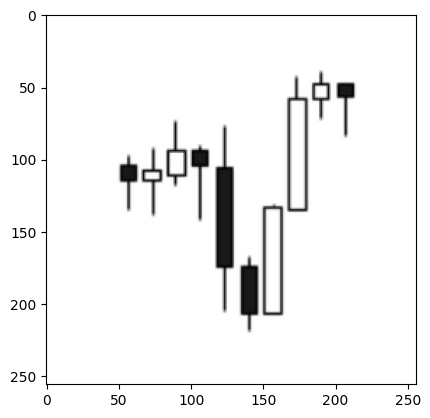

In [11]:
index = 40

classes, _ = get_classes_and_files()

print(classes)
print(predictions[index])
print("Actual Result:", classes[y_predict[index]])
print("Predicted Result:", classes[predicted_classes[index]])

img = predicted_classes[index]
plt.imshow(x_predict[index])